In [27]:
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
import random
from collections import deque
import os
import matplotlib.pyplot as plt

1) More actions, less actions: What are appropriate number of actions to discretise the range -2.0 to 2.0?
2) Stability of training, i.e. should you train longer or cut it off within some number of episodes?
3) Track the reward, save weights, plot performance. Reproduce your best possible agent by loading your best weights and test it for say, 10 times. Does it consistently balance the pendulum for all 10 times when tested?
4) Exploration vs exploitation (the epsilon hyperparameter). Should you decay it?
5) Explain the differences between this code and the lab code for cartpole.

# NO NEED GPU! CPU will do!

In [8]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [34]:
class DQN:
    def __init__(self,
                 InputShape = 4,
                 NActions = 2,
                 Gamma = 0.95,  # Discount rate
                 epsilon = 1.0,  # Exploration rate
                 epsilon_min = 0.1,
                 epsilon_decay = 0.995,
                 learning_rate = 0.01,
                 ReplayMemorySize = 10000,
                 MinReplayMemory = 1000,
                 UpdateTargetEveryThisEpisodes = 1,
                 IntermediateSize = 64,
                 BatchSize = 32,
                optimizer = Adam()):
        
        # Hyperparameters. #
        
        self.InputShape = InputShape
        self.NActions = NActions
        self.Gamma = Gamma
        self.ReplayMemorySize = ReplayMemorySize
        self.MinReplayMemory = MinReplayMemory
        self.UpdateTargetEveryThisEpisodes = UpdateTargetEveryThisEpisodes
        self.IntermediateSize = IntermediateSize
        self.BatchSize = BatchSize
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        
        self.total_reward = 0  # Initialize total reward accumulator
        self.episode_rewards = []  # List to store rewards for each episode
        self.average_rewards = []
    


        # Main model. #
        
        self.Main = self.CreateModel('Main')
        self.Optimiser = Adam()
        
        # Target model. #
        
        self.Target = self.CreateModel('Target')
        self.Target.set_weights(self.Main.get_weights())
        
        # Replay memory. #
        
        self.ReplayMemory = deque(maxlen = ReplayMemorySize)
        
        # Target network update counter. #
        
        self.TargetUpdateCounter = 0

    def save_weights(self, dir_path):
        print(f'Saving weights to {dir_path}')
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        Main_path = os.path.join(dir_path, 'Main')
        Target_path = os.path.join(dir_path, 'Target')
        self.Main.save_weights(Main_path + '_main.weights.h5')
        self.Target.save_weights(Target_path + '_target.weights.h5')
    
    
    def load_weights(self, path):
        print(f'Loading weights from {path}')
        Main_path = os.path.join(path, 'Main')
        Target_path = os.path.join(path, 'Target')
        self.Main.load_weights(Main_path + '_main.weights.h5')
        self.Target.load_weights(Target_path + '_target.weights.h5')

    def moving_average (self, values, window):
        weights = np.repeat(1.0, window)/window
        return np.convolve(values, weights, 'valid')
    
    def plot_rewards(self):
        plt.figure(figsize=(20, 5))
        plt.plot(self.episode_rewards, marker='o')
        plt.plot(self.moving_average(self.episode_rewards, 10), marker='o')
        plt.title('Episode Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.grid(True)
        plt.show()

    def plot_avg_rewards(self):
        plt.figure(figsize=(20, 5))
        plt.plot(self.average_rewards, marker='o')
        plt.plot(self.moving_average(self.average_rewards, 10), marker='o')
        plt.title('Episode Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.grid(True)
        plt.show()


    def CreateModel(self, Type):
        inputs = Input(shape = (self.InputShape,), name = 'Input')
        x = Dense(self.IntermediateSize, activation = 'relu', name = '1stHiddenLayer')(inputs)
        x = Dense(self.IntermediateSize, activation = 'relu', name = '2ndHiddenLayer')(x)
        outputs = Dense(self.NActions, activation = 'linear', name = 'Output')(x)
        
        NN = Model(inputs, outputs, name = f'{Type}')
        NN.summary()
        
        return NN
    
    def UpdateReplayMemory(self, Information): # Information = (state, action, reward, SNext, Done)
        self.ReplayMemory.append(Information)

        # Epsilon-Greedy Policy to choose action
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            # pull random action (exploration)
            return random.randrange(self.action_size)
        # else pull current-best action (greedy; exploitation)
        act_values = self.model.predict(state, verbose = 0)
        return np.argmax(act_values[0])


    def Train(self, EndOfEpisode, reward):
        self.total_reward += reward  # Accumulate reward for the current episode

        # Only train if replay memory has enough data. #
        
        if len(self.ReplayMemory) < self.MinReplayMemory:
            print(f'DID NOT TRAIN..., replay memory = {len(self.ReplayMemory)}')
            return
        
        # Get batch of data for training. #
        
        TrainingData = random.sample(self.ReplayMemory, self.BatchSize)
        
        # Get states from training data, then get corresponding Q values. #
        
        ListOfS = np.array([element[0] for element in TrainingData])
        ListOfQ = np.array(self.Main(ListOfS))
        
        # Get future states from training data, then get corresponding Q values. #
        
        ListOfSNext = np.array([element[3] for element in TrainingData])
        ListOfQNext = self.Target(ListOfSNext)
        
        # Build actual training data for neural network. #
        
        X = []
        Y = []
        for index, (state, action, reward, SNext, Done) in enumerate(TrainingData):
            if not Done:
                MaxQNext = np.max(ListOfQNext[index])
                QNext = reward + self.Gamma * MaxQNext
            else:
                QNext = reward
            Q = ListOfQ[index]
            Q[action] = QNext
        
            X.append(state)
            Y.append(Q)
        
        # Train model using tf.GradientTape(), defined below.
    
        self.GTfit(X, Y)
                
        # Update target network every episode. #
        
        if EndOfEpisode:
            self.episode_rewards.append(self.total_reward)  # Store total reward for the episode
            self.total_reward = 0  # Reset total reward for the next episode
            self.TargetUpdateCounter += 1

        
        # Update target if counter is full. #
        
        if self.TargetUpdateCounter >= self.UpdateTargetEveryThisEpisodes:
            self.Target.set_weights(self.Main.get_weights())
            self.TargetUpdateCounter = 0

        # Decay epsilon gradually
        # if self.epsilon > self.epsilon_min:
        #     self.epsilon *= self.epsilon_decay
        #     print('epsilon:', self.epsilon)


    # This is the tf.GradientTape() which significantly speeds up training of neural networks
    @tf.function
    def GTfit(self, X, Y):
        
        # Train the neural network with this batch of data. #
        
        with tf.GradientTape() as tape:
            Predictions = self.Main(tf.convert_to_tensor(X), training = True)
            Loss = tf.math.reduce_mean(tf.math.square(tf.convert_to_tensor(Y) - Predictions))
        Grad = tape.gradient(Loss, self.Main.trainable_variables)
        self.Optimiser.apply_gradients(zip(Grad, self.Main.trainable_variables))

In [10]:
EnvName = 'Pendulum-v0'
IntermediateSize = 64
Epsilon_min = 0.1
Epsilon_decay = 0.99
Epsilon = 1.0
ShowEvery = 10
InputShape = 3
NActions = 20


In [11]:
def PendulumActionConverter(action, NActions=NActions):
    ActualTorque = (action / NActions - 0.5) * 4
    return ActualTorque

def PendulumInverseActionConverter(action, NActions=NActions):
    ActualA = round((action + 2) * (NActions - 1) / 4)
    return(ActualA)

def OneEpisode(DQN):
    env = gym.make(f'{EnvName}')
    state = env.reset()
    ListOfRewards = []
    Done = False
    global Epsilon
    while not Done:
        Q = DQN.Main(state.reshape(-1, state.shape[0]))
        if np.random.rand() < Epsilon:
            AStep = env.action_space.sample()
            action = PendulumInverseActionConverter(AStep[0])
        else:
            action = np.argmax(Q)
            action = PendulumActionConverter(action)
            AStep = np.array([action])
            action = PendulumInverseActionConverter(action)
        #Epsilon *= Epsilon_decay 
        if not _ % ShowEvery and len(DQN.ReplayMemory) >= DQN.MinReplayMemory:
            env.render()
        SNext, reward, Done, Info = env.step(AStep)
        DQN.UpdateReplayMemory((state, action, reward, SNext, Done))
        DQN.Train(Done, reward)
        ListOfRewards.append(reward)

        if Done:
            print(f'Finished! | Return: {np.sum(ListOfRewards)} | average reward: {np.mean(ListOfRewards)}')
            env.close()
            return ListOfRewards
        state = SNext

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,716 (22.33 KB)

 Trainable params: 5,716 (22.33 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,716 (22.33 KB)

 Trainable params: 5,716 (22.33 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


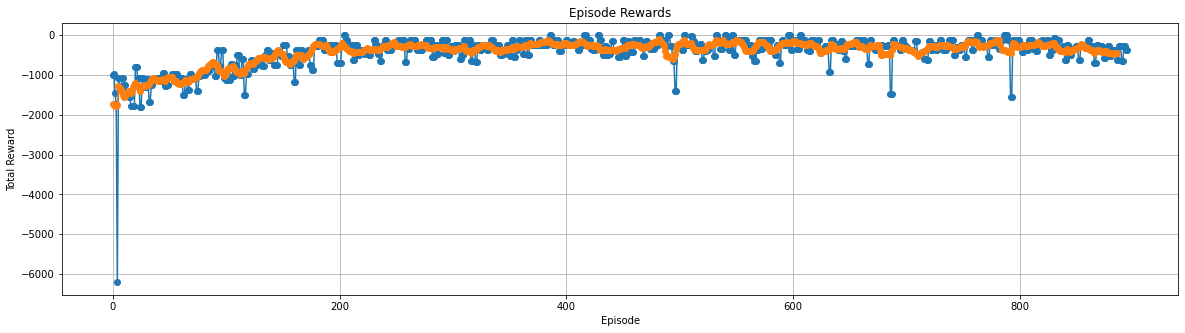

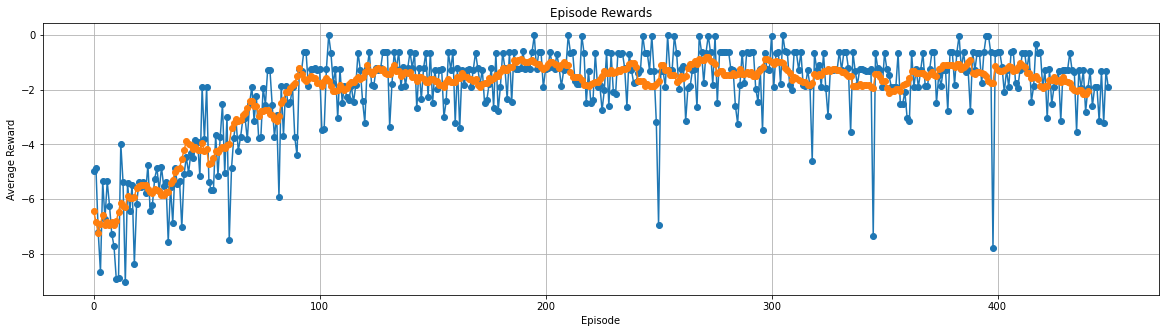

In [12]:
import time
STARTTIME = time.time()

dqn = DQN(InputShape = InputShape, NActions = NActions)
dir_path='best_dqn_weights'
# dqn.load_weights(path=dir_path)

Epsilon = 1.0
EPISODES = 450
best_reward = -1000
avg_reward = []
for _ in range(EPISODES):

    print(f'Episode {_}')
    reward = OneEpisode(dqn)
    if Epsilon > Epsilon_min:
        Epsilon *= Epsilon_decay 
        print('Epsilon:',Epsilon)

    dqn.episode_rewards.append(np.sum(reward))
    dqn.average_rewards.append(np.mean(reward))
    print(f'Best reward: {best_reward}')
    if np.mean(reward) > best_reward:
        best_reward = np.mean(reward)
        dir_path = 'best_dqn_weights'
        print(f'Saving best model weights for episode {_} with reward {np.mean(reward)}')
        dqn.save_weights(dir_path=dir_path)



 
        


print(f'Total time taken: {time.time() - STARTTIME} seconds ...')


# Plot rewards
dqn.plot_rewards()

dqn.plot_avg_rewards()



In [14]:
def play():
    env = gym.make(f'{EnvName}')
    state = env.reset()
    ListOfRewards = []
    Done = False
    while not Done:
        Q = dqn.Main(state.reshape(-1, state.shape[0]))
        action = np.argmax(Q)
        action = PendulumActionConverter(action)
        AStep = np.array([action])
        action = PendulumInverseActionConverter(action)
        env.render()
        SNext, reward, Done, Info = env.step(AStep)

        state = SNext
    env.close()

In [30]:
dqn = DQN(InputShape = InputShape, NActions = NActions)

# Test the best agent by loading the best weights
dir_path = 'best_dqn_weights'

dqn.load_weights(path=dir_path)
Epsilon = 0
test_episodes = 10
test_rewards = []
for _ in range(test_episodes):
    print(f'Episode {_}')
    reward = OneEpisode(dqn)
    test_rewards.append(reward)
    print(Epsilon)

print(f'Test Rewards: {test_rewards}')
print(f'Average Test Reward: {np.mean(test_rewards)}')

play()


Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,716 (22.33 KB)

 Trainable params: 5,716 (22.33 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,716 (22.33 KB)

 Trainable params: 5,716 (22.33 KB)

 Non-trainable params: 0 (0.00 B)

Loading weights from best_dqn_weights
Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26

# HYPERTUNING 

In [40]:

optimizer_list = [
    Adam(),
    Adam(learning_rate=0.05),
    Adam(learning_rate=0.0002),
    SGD(learning_rate=0.005),
    SGD(learning_rate=0.05),
    SGD()
]

name_list = [
    'Adam_LR_0.001',
    'Adam_LR_0.005',
    'Adam_LR_0.0002',
    'SGD_LR_0.005',
    'SGD_LR_0.05',
    'SGD_LR_0.01'
]

tuned_Adam_LR_0_001 = None
tuned_Adam_LR_0_005 = None
tuned_Adam_LR_0_0002 = None
tuned_SGD_LR_0_005 = None
tuned_SGD_LR_0_05 = None
tuned_SGD_LR_0_01 = None


tuned_Adam_LR_0_001_arr = []
tuned_Adam_LR_0_005_arr = []
tuned_Adam_LR_0_0002_arr = []
tuned_SGD_LR_0_005_arr = []
tuned_SGD_LR_0_05_arr = []
tuned_SGD_LR_0_01_arr = []

model_list = [tuned_Adam_LR_0_001, tuned_Adam_LR_0_005, tuned_Adam_LR_0_0002, tuned_SGD_LR_0_005, tuned_SGD_LR_0_05, tuned_SGD_LR_0_01]



def model_hypertuner(optimizer, name, model, train_length=200):
    dqn = DQN(InputShape = InputShape, NActions = NActions, optimizer=optimizer)
    dqn.load_weights(path='best_dqn_weights')
    print(dqn.optimizer)
    print(dqn.learning_rate)
    Epsilon = 1.0
    EPISODES = train_length
    best_reward = -1000
    avg_reward = []
    for _ in range(EPISODES):

        print(f'Episode {_}')
        reward = OneEpisode(dqn)
        if Epsilon > Epsilon_min:
            Epsilon *= Epsilon_decay 
            print('Epsilon:',Epsilon)

        dqn.episode_rewards.append(np.sum(reward))
        dqn.average_rewards.append(np.mean(reward))
        print(f'Best reward: {best_reward}')
        if np.mean(reward) > best_reward:
            best_reward = np.mean(reward)
            dir_path = 'best_dqn_weights_hp_' + name
            print(f'Saving best model weights for episode {_} with reward {np.mean(reward)}')
            dqn.save_weights(dir_path=dir_path)
    play()
    return dqn, dqn.episode_rewards, dqn.average_rewards

def hypertune(optimizer_list, name_list, model_list):
    output_model_list = []
    output_episode_rewards = []
    output_average_rewards = []

    for optimizer, name, model in zip(optimizer_list, name_list, model_list):
        model, episode_rewards, average_rewards = model_hypertuner(optimizer, name, model, train_length=30)
        output_model_list.append(model)
        output_episode_rewards.append(episode_rewards)
        output_average_rewards.append(average_rewards)

    return output_model_list, output_episode_rewards, output_average_rewards

model_list, episode_rewards_list, average_reward_list = hypertune(optimizer_list, name_list, model_list)


Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,716 (22.33 KB)

 Trainable params: 5,716 (22.33 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,716 (22.33 KB)

 Trainable params: 5,716 (22.33 KB)

 Non-trainable params: 0 (0.00 B)

Loading weights from best_dqn_weights
0.01
Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,716 (22.33 KB)

 Trainable params: 5,716 (22.33 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,716 (22.33 KB)

 Trainable params: 5,716 (22.33 KB)

 Non-trainable params: 0 (0.00 B)

Loading weights from best_dqn_weights
0.01
Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,716 (22.33 KB)

 Trainable params: 5,716 (22.33 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,716 (22.33 KB)

 Trainable params: 5,716 (22.33 KB)

 Non-trainable params: 0 (0.00 B)

Loading weights from best_dqn_weights
0.01
Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory

KeyboardInterrupt: 

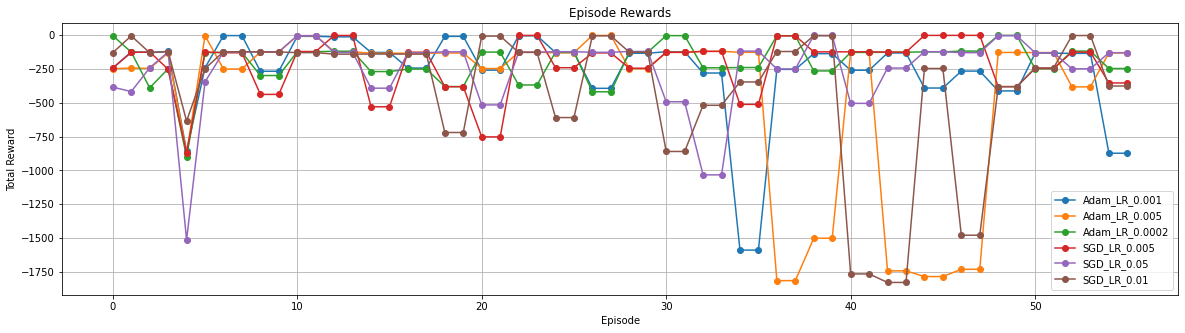

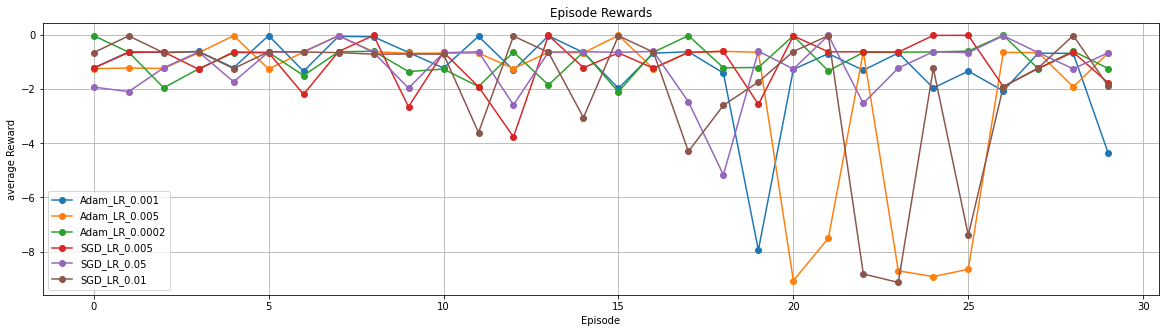

In [39]:
plt.figure(figsize=(20, 5))
for history, name in zip(episode_rewards_list, name_list):
    plt.plot(history, marker='o', label=name)
    dqn.moving_average(history, 10)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
for history, name in zip(average_reward_list, name_list):
    plt.plot(history, marker='o', label=name)
    dqn.moving_average(history, 10)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('average Reward')
plt.grid(True)
plt.legend()
plt.show()
